# A Comprehensive Data Analysis on a WhatsApp Group Chat
##### *Author*: [Tushar Nankani](https://www.linkedin.com/in/tusharnankani/)

## *Overview*
- Introduction
- Data Retrieval & Preprocessing
- Exploratory Data Analysis
- Data Visualization
- Data Interpretation
- Summarizing the Inferences
- Conclusion

# *Introduction*:

Whatsapp has quickly become the world’s most popular text and voice messaging application. Specializing in cross-platform messaging with over 1.5 billion monthly active users, this makes it the most popular mobile messenger app worldwide.


- I thought of various projects on which I could analyse data like - *Air Quality Index* or The *cliched* *Covid-19 Data Analysis*.

- But I thought why not do **Data Analysis on a WhatsApp group chat** of *college students* and find out interesting insights about *who is most active, who are ghosts (the ones who do not reply), my sleep schedule,* *the most used emoji, the sentiment score of each person, who swears the most, the most actives times of the day, or does the group use phones during college teaching hours?*

- These would be some interesting insights for sure, more for me than for you, since the people in this chat are people I know personally.


## Beginning. How do I export my conversations? From Where To Obtain Data?

- The first step is **Data Retrieval & Preprocessing**, that is to **gather the data**. WhatsApp allows you to **export your chats** through a **.txt format**.

- Go to the respective chat, which you want to export!

<img src="https://imgur.com/lYd4A4J.png" width=200 length=200 align="center">
<!-- ![](https://imgur.com/lYd4A4J) -->

- Tap on **options**, click on **More**, and **Export Chat.**

<img src="https://imgur.com/KD0vCs1.png" width=200 length=200 align="center">
<!-- ![](https://imgur.com/KD0vCs1.png) -->

- I will be Exporting **Without Media.**

#### NOTE:
- Without media: exports about **40k messages **
- With media: exports about *10k messages along with pictures/videos*
- While exporting data, *avoid including media files* because if the number of media files is greater than certain figure then not all the media files are exported.

<img src="https://imgur.com/BlQx2dl.png" width=300 length=300 align="center">
<!-- ![](https://imgur.com/BlQx2dl) -->

## Opening this .txt file up, you get messages in a format that looks like this:

![](https://imgur.com/EINDP1F.png)


# *Importing Necessary Libraries*

We will be using :
1. **Regex (re)** to extract and manipulate strings based on specific patterns.
    - References:
        - [Regex - Python Docs](https://docs.python.org/3/library/re.html)
        - [Regex cheatsheet](https://www.rexegg.com/regex-quickstart.html)
        - [Regex Test - live](https://regexr.com/)
        - [Datetime Format](http://strftime.org/)
2. **pandas** for analysis.
3. **matlotlib** and **seaborn** for visualization.
4. **emoji** to deal with emojis.
    - References:
        - [Python Docs](https://pypi.org/project/emoji/)
        - [Emoji](https://github.com/carpedm20/emoji)
        - [EMOJI CHEAT SHEET](https://www.webfx.com/tools/emoji-cheat-sheet/)
5. **wordcloud** for the most used words.

In [1]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 7.5 MB/s eta 0:00:00


In [2]:

import re
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
import itertools
from collections import Counter
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

##### NOTE:
- This special command `%matplotlib inline` to ensure that plots are shown and embedded within the Jupyter notebook itself. Without this command, sometimes plots may show up in pop-up windows.
- `warnings.filterwarnings('ignore')`: The warnings filter controls whether warnings are ignored, displayed, or turned into errors (raising an exception). [REFERENCE](https://docs.python.org/3/library/warnings.html)

## *Preparation and reading data*

In [3]:
def rawToDf(file, key):
    '''Converts raw .txt file into a Data Frame'''

    split_formats = {
        '12hr': r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr': r'\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom': ''
    }
    datetime_formats = {
        '12hr': '%d/%m/%y, %I:%M %p - ',
        '24hr': '%d/%m/%y, %H:%M - ',
        'custom': ''
    }

    with open(file, 'r', encoding='utf-8') as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n'))
        user_msg = re.split(split_formats[key], raw_string)[1:]
        date_time = re.findall(split_formats[key], raw_string)

        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg})

    # Convert date-time string to datetime format
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key], errors='coerce')

    # Split user and msg
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i)
        if a[1:]:
            usernames.append(a[1])
            msgs.append(a[2])
        else:
            usernames.append("group_notification")
            msgs.append(a[0])

    df['user'] = usernames
    df['message'] = msgs
    df.drop('user_msg', axis=1, inplace=True)

    return df


#### *NOTE*:
- Since WhatsApp texts are *multi-line*, you cannot just read the file line by line and get each message that you want. Instead, you need a way to *identify* if a line is a new message or part of an old message. You could use regular expressions.
- While reading each line, I split it based on a comma and take the first item returned from the `split()` function. If the line is a new message, the first item would be a valid date, and it will be appended as a new message to the list of messages. If it’s not, the message is part of the previous message, and hence, will be appended to the end of the previous message as one continuous message.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = rawToDf('/content/drive/MyDrive/chat.txt', '12hr')

## *Prior Information of my Whatsapp Data*
- This is my most active college coding group.
- It has **235+** participants; 237 to be precise.
- This group was made in **January 2020.**

## Pre-Processing

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10577 entries, 0 to 10576
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date_time  10577 non-null  datetime64[ns]
 1   user       10577 non-null  object        
 2   message    10577 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 248.0+ KB


### The dataset contains 3 rows, and 13655 respective entries.
- Here is how it looks like:

In [8]:
df.sample(10)

,date_time,user,message
2566,2023-05-01 18:48:00,Akhila,
3399,2023-06-06 10:23:00,+91 98862 14141,<Media omitted>
8937,2024-01-05 09:58:00,Dr Suresh,ASAP
6054,2023-09-18 09:05:00,+91 97401 51846,<Media omitted>
4578,2023-07-14 08:54:00,+91 97005 61700,Noted Sir.
2251,2023-04-18 12:28:00,Dr Prachi Beriwala,<Media omitted>
6727,2023-10-25 10:16:00,+91 99165 95937,MF03
3276,2023-05-31 20:28:00,+91 81975 46238,The 1st Class Committee meeting for MBA 2nd se...
7056,2023-11-06 10:08:00,+91 77608 55625,"Bharsni Sir, need 1 main booklet - MF03."
8207,2023-12-16 18:16:00,Dr Prachi Beriwala,Those who can follow kannada can listen to thi...


### An important observation
- One might wonder there are no NaNs, but as you can see, there are some rows, where messages are an *empty string.*
- This can be because, the message might just contain **emojis.**
#### To see, how many such rows are there, we can use `df[df['message'] == ""].shape[0]`

In [9]:
df[df['message'] == ""].shape[0]

270

## Adding extra *helper columns for analysis and visualization*

In [10]:
df['day'] = df['date_time'].dt.strftime('%a')
df['month'] = df['date_time'].dt.strftime('%b')
df['year'] = df['date_time'].dt.year
df['date'] = df['date_time'].apply(lambda x: x.date())

# Now that we have a clean DataFrame to work with, it’s time to perform analysis on it.
### Final Data Frame

In [11]:
df

,date_time,user,message,day,month,year,date
0,2022-12-02 14:31:00,group_notification,Messages and calls are end-to-end encrypted. N...,Fri,Dec,2022,2022-12-02
1,2022-12-02 14:31:00,group_notification,~ Laxmiprabha added you,Fri,Dec,2022,2022-12-02
2,2022-12-02 14:32:00,+91 99021 60749,Added Dr Krishnan Hariharan,Fri,Dec,2022,2022-12-02
3,2022-12-02 14:32:00,+91 99021 60749,Welcome to SoM group sir 💐,Fri,Dec,2022,2022-12-02
4,2022-12-02 14:32:00,group_notification,~ Laxmiprabha added Mohammed Mansoor,Fri,Dec,2022,2022-12-02
...,...,...,...,...,...,...,...
10572,2024-03-03 18:07:00,Dr. Vijay Vardhan M,Thank you all for your encouragement and suppo...,Sun,Mar,2024,2024-03-03
10573,2024-03-03 18:19:00,+91 99165 95937,👍🏻 Congratulations Dr+Dr Vijay,Sun,Mar,2024,2024-03-03
10574,2024-03-03 18:23:00,+91 94431 45398,<Media omitted>,Sun,Mar,2024,2024-03-03
10575,2024-03-03 18:23:00,+91 94431 45398,Dear Professors Please follow deadline,Sun,Mar,2024,2024-03-03


# *Data Analysis*

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist).**
- Ghosts present in the group. (shocking results.)

**4. Top 10 users most sent media.**

**5. Top 10 most used emojis.**

**6. Most active hours and days.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

# 1. Overall frequency of total messages on the group.
- I will first do this to get a look at overall data.

I will plot a simple line graph to see the frequency of messages over the months.
##### I expect to see a nice line graph with crests and troughs in odd places.

In [12]:
df1 = df.copy()      # I will be using a copy of the original data frame everytime, to avoid loss of data!
df1['message_count'] = [1] * df1.shape[0]      # adding extra helper column --> message_count.
df1.drop(columns='year', inplace=True)         # dropping unnecessary columns, using `inplace=True`, since this is copy of the DF and won't affect the original DataFrame.
df1 = df1.groupby('date').sum().reset_index()  # grouping by date; since plot is of frequency of messages --> no. of messages / day.
df1

,date,message_count
0,2022-12-02,27
1,2022-12-03,53
2,2022-12-04,86
3,2022-12-05,61
4,2022-12-06,51
...,...,...
375,2024-02-28,42
376,2024-02-29,33
377,2024-03-01,29
378,2024-03-02,8


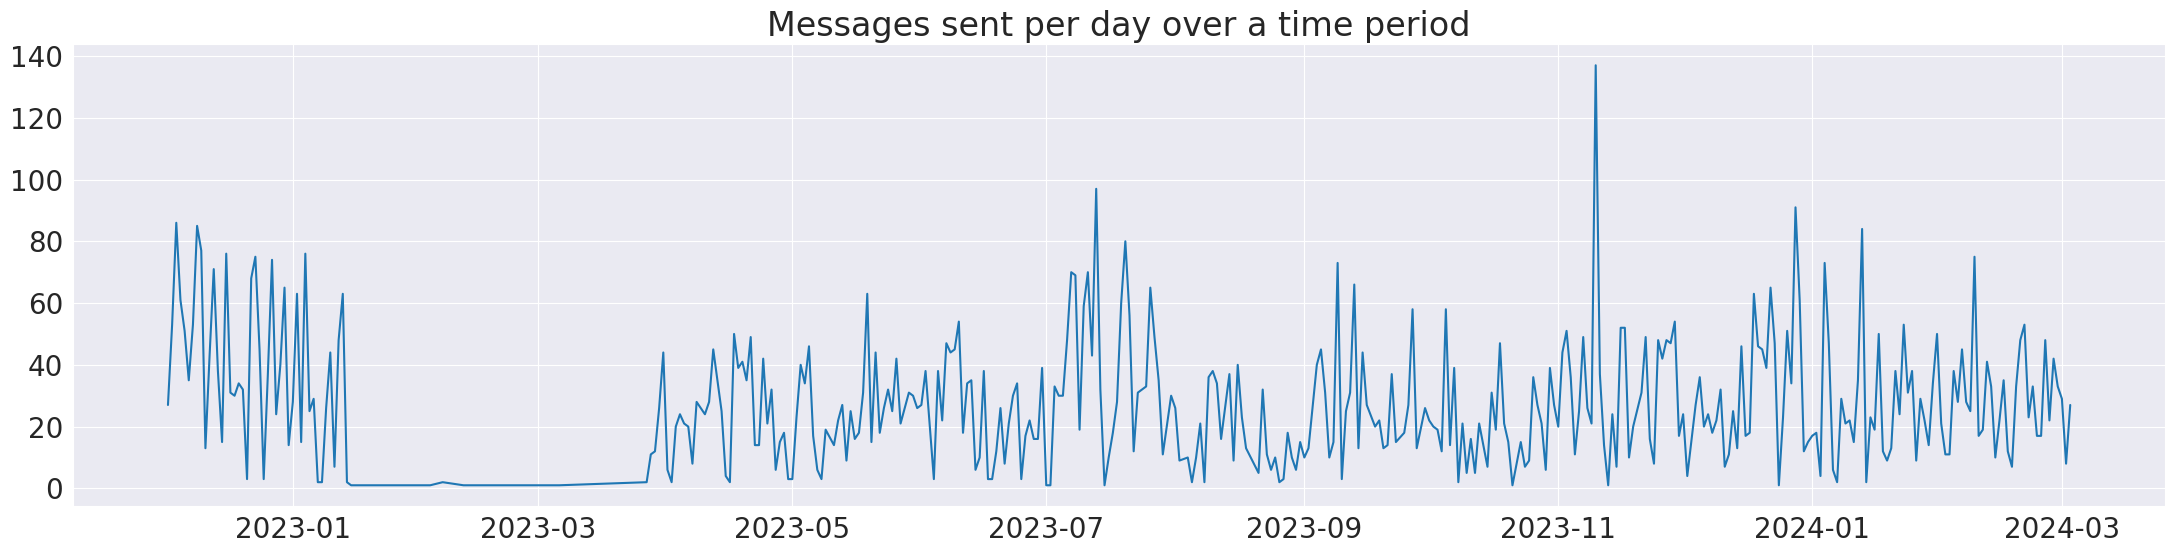

In [13]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (27, 6)      # Same as `plt.figure(figsize = (27, 6))`


# A basic plot
plt.plot(df1.date, df1.message_count)
plt.title('Messages sent per day over a time period');

# Could have used Seaborn's lineplot as well.
# sns.lineplot(df1.date, df1.message_count);


# Saving the plots
plt.savefig('msg_plots.svg', format = 'svg')

# 2 *Top 10 most active days.*

In [14]:
top10days = df1.sort_values(by="message_count", ascending=False).head(10)    # Sort values according to the number of messages per day.
top10days.reset_index(inplace=True)           # reset index in order.
top10days.drop(columns="index", inplace=True) # dropping original indices.
top10days

,date,message_count
0,2023-11-10,137
1,2023-07-13,97
2,2023-12-28,91
3,2022-12-04,86
4,2022-12-09,85
5,2024-01-13,84
6,2023-07-20,80
7,2022-12-10,77
8,2022-12-16,76
9,2023-01-04,76


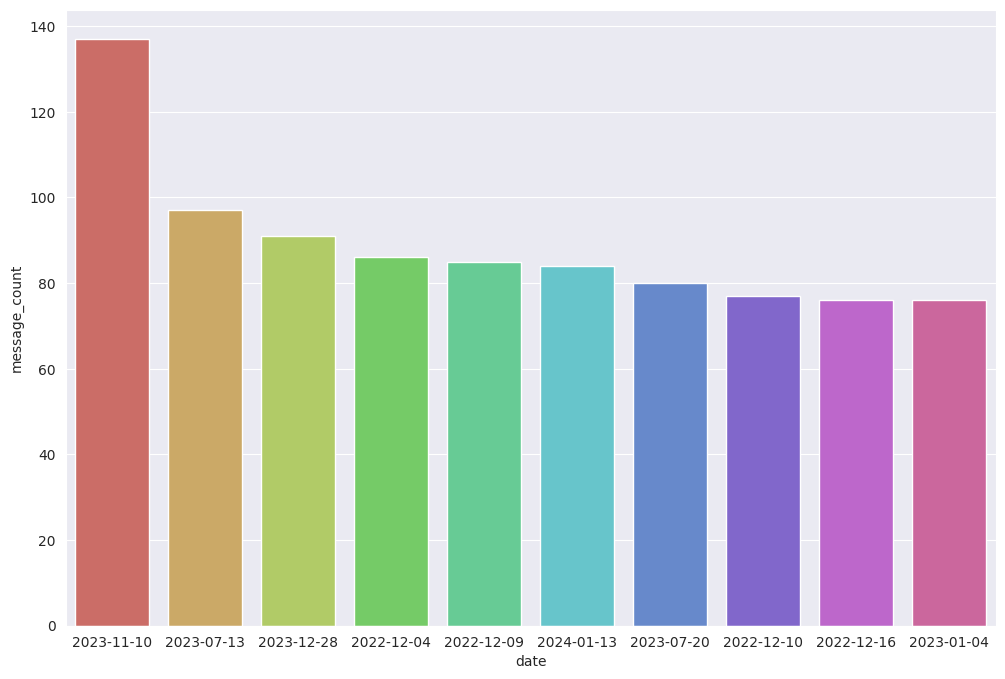

In [15]:
# Improving Default Styles using Seaborn
sns.set_style("darkgrid")

# For better readability;
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 10
matplotlib.rcParams['figure.figsize'] = (12, 8)

# A bar plot for top 10 days
sns.barplot(x='date', y='message_count', data=top10days, palette="hls")

# Saving the plots
plt.savefig('top10_days.svg', format='svg')


#### Apparently, the group was very active on 13th Spetember'20
- Because we were discussing fundamental yet tricky and brain-wracking "Guess the Output" Java questions!

# 3. Top 10 active users on the group.

### Before, analysing that, we will see the *number of Ghosts* in the group.

In [16]:
# Total number of people who have sent at least one message on the group;
print(f"Total number of people who have sent at least one message on the group are {len(df.user.unique()) - 1}")   # `-1` because excluding "group_notficiation"

print(f"Number of people who haven't sent even a single message on the group are {237 - len(df.user.unique()) - 1}")

Total number of people who have sent at least one message on the group are 96
Number of people who haven't sent even a single message on the group are 139


### *Shocking Result*
- Total number of people who have sent at least one message on the group are **154**.
- BUT, the total number of participants were **237**.
- **That means 81 people in the group have not sent even a single message throughout these 9 months and 13500+ messages.**

## Now, pre-processing top 10 active users.

In [17]:
df2 = df.copy()
df2 = df2[df2.user != "group_notification"]
top10df = df2.groupby("user")["message"].count().sort_values(ascending=False)

# Final Data Frame
top10df = top10df.head(10).reset_index()
top10df

,user,message
0,+91 94431 45398,920
1,+91 81975 46238,570
2,Akhila,479
3,+91 90070 39508,442
4,+91 97861 99889,384
5,Dr Prachi Beriwala,371
6,Dr Arnav,365
7,+91 99162 66127,321
8,+91 97401 51846,320
9,+91 99165 95937,316


## Now, visualizing top 10 active users.
### *Replacing names with initials for better visualization*

In [18]:
top10df['initials'] = ''
for i in range(10):
    # Check if there are at least two parts after splitting
    user_parts = top10df.user[i].split()
    if len(user_parts) >= 2:
        top10df.initials[i] = user_parts[0][0] + user_parts[1][0]

# Assigning "PB" to initials for a specific row
top10df.initials[5] = "PB"
top10df.initials[2] = "AK"

### Starting with a basic plot.
- [Color References for Matplotlib](https://matplotlib.org/3.1.0/gallery/color/named_colors.html)

- **Improving Default Styles using Seaborn**

    - [References](https://seaborn.pydata.org/generated/seaborn.set_style.html)

In [19]:
# For better readablity;
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

## *Now, I will be trying different visualization methods.*

##### Plotting a simple line graph.

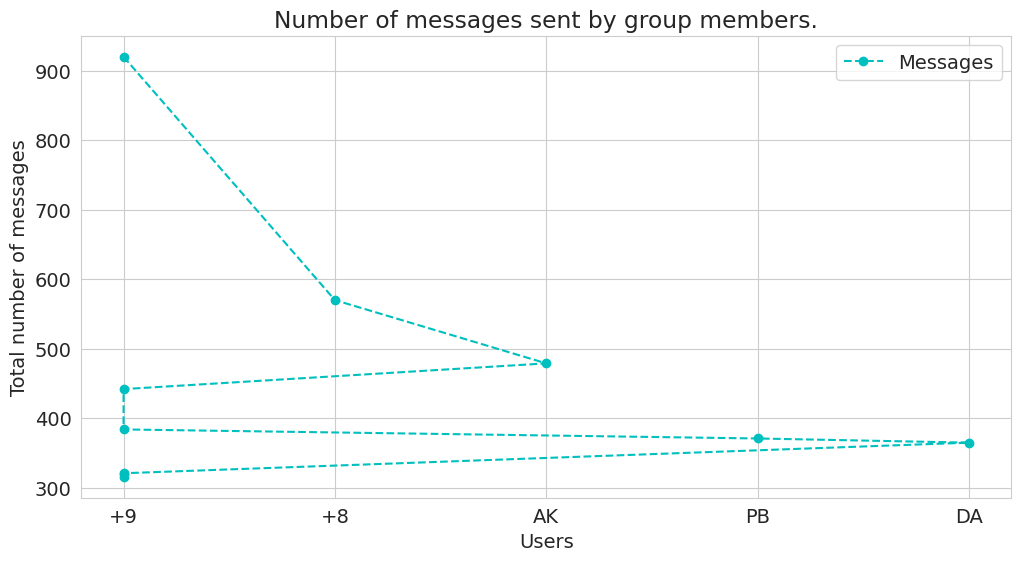

In [20]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))


# plt.plot(top10df.initials, top10df.message, marker='o', ls='--', c='cyan')

# BETTER IMPLEMENTATION using the `fmt` argument;
plt.plot(top10df.initials, top10df.message, 'o--c')


# Labels and Title
plt.xlabel('Users')
plt.ylabel('Total number of messages')

plt.title("Number of messages sent by group members.")
plt.legend(['Messages']);

# Saving the plots
# plt.savefig('msg_plots.svg', format = 'svg')

#### *Plotting a bar chart and line graph together.*

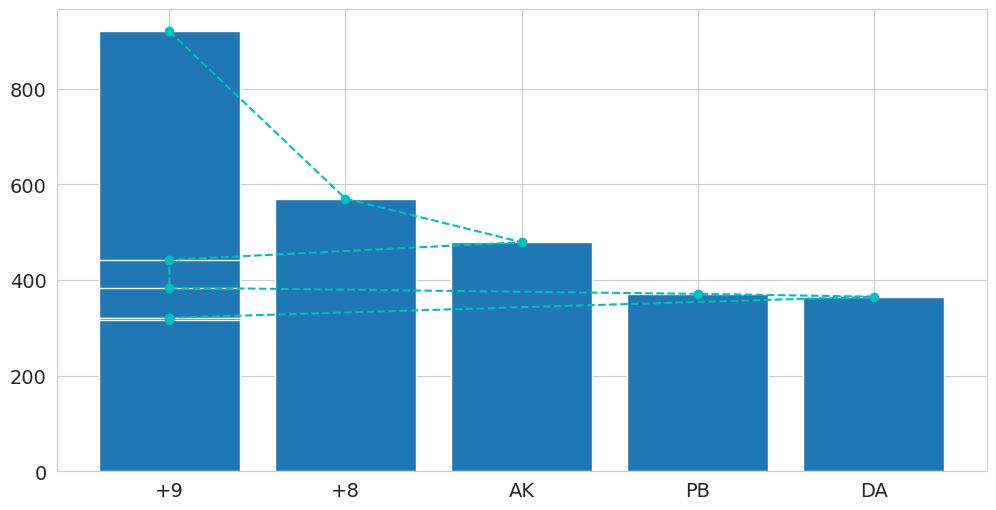

In [21]:
# Improving Default Styles using Seaborn
sns.set_style("whitegrid")

# Increasing the figure size
plt.figure(figsize=(12, 6))

plt.bar(top10df.initials, top10df.message)   # basic bar chart
plt.plot(top10df.initials, top10df.message, 'o--c');   # line chart

### *Beautifying Default Styles using Seaborn*

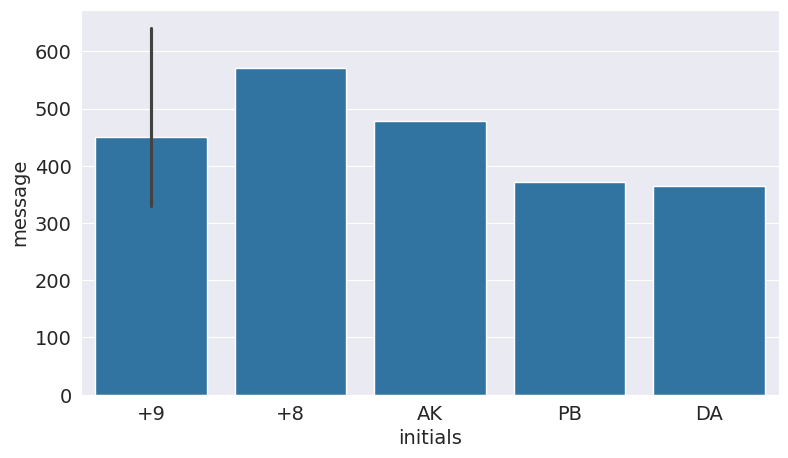

In [22]:
# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")
sns.barplot(x='initials', y='message', data=top10df);


# *Important Note*

- Since almost all the plots will be ***comparing* one person with another**, I’ll assign a **specific colour to each person** so that it becomes **easy to identify** each person among *multiple plots*.

- I could've used *seaborn's color palette* but:
    - Seaborn assigns default colors itself, but i wanted the color of a **certain person remains the same, no matter the plot**;
    - Also, I wanted to try some different colors so I grabbed my **colour palette** from https://coolors.co/

- Next, I made a dictionary where each key is the name and the value for each would be their assigned colour. I create a function which reorders colours given a list of names to match the ordering of the plot. This function takes the ordered names as input and returns a reordered list of colours. This list has to be passed into the `pallete` argument in a seaborn plotting function.

## Defining a function to tackle the problem.

I'm defining the following function to ***maintain consistent colors for each person across all plots***. Since the order will vary depending on the plot, this is passed to the function which will reorder colors in a particular order so that **the color of a certain person remains the same no matter the plot**. This will help maintain **consistency and readability** amongst the many graphs I will be plotting.


In [23]:
def get_colors_of_certain_order(names_in_certain_order):
    '''the color of a certain person remains the same, no matter the plot'''

    order = list(names_in_certain_order)
    return_list = []

    for name in order:
        return_list.append(color_dict[name])

    return return_list

### Now, we have a really nice set of colours for each person, with which we can visualize using `sns.palplot`.

{'+9': '#003F88',
 '+8': '#F3722C',
 'AK': '#F8961E',
 'PB': '#90BE6D',
 'DA': '#43AA8B'}

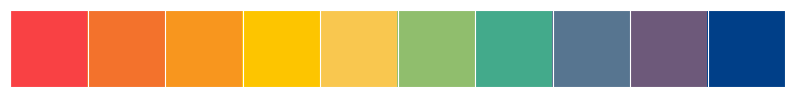

In [24]:
colors = ['#F94144', '#F3722C', '#F8961E', '#FDC500', '#F9C74F', '#90BE6D', '#43AA8B', '#577590', '#6D597A','#003F88']
sns.palplot(colors)    # visualizing the colors' list

names = top10df.initials

color_dict = {}
for name, color in zip(names, colors):
    color_dict[name] = color
color_dict

## Now, finding the *average message length* of the 10 most active users of the group.

In [25]:
# Adding another column for message length; using the apply method;
df2['message_length'] = df2['message'].apply(lambda x: len(x))

# Creating another dataframe for average length per user;
avg_msg_lengths = df2.groupby(df2.user).mean().reset_index().sort_values(by = 'message_length', ascending = False)

# Creating helper columns;
top10df['avg_message_length'] = [0] * 10
i, j = 0, 0
while i < 10:
    if top10df['user'][i] == avg_msg_lengths['user'][j]:
        top10df['avg_message_length'][i] = avg_msg_lengths['message_length'][j]
        i += 1
        j = -1
    j += 1

# Sorting the average message lengths of the same to 10 active users;
top10df_msg = top10df.sort_values(by = "avg_message_length", ascending=False)

## Now, we will be plotting *most sent messages* and respective *average message lengths* simultaneously, to see some interesting results.
- Plotting multiple charts in a grid
    - Matplotlib and Seaborn also support plotting multiple charts in a grid, using `plt.subplots`, which returns a set of axes that can be used for plotting.

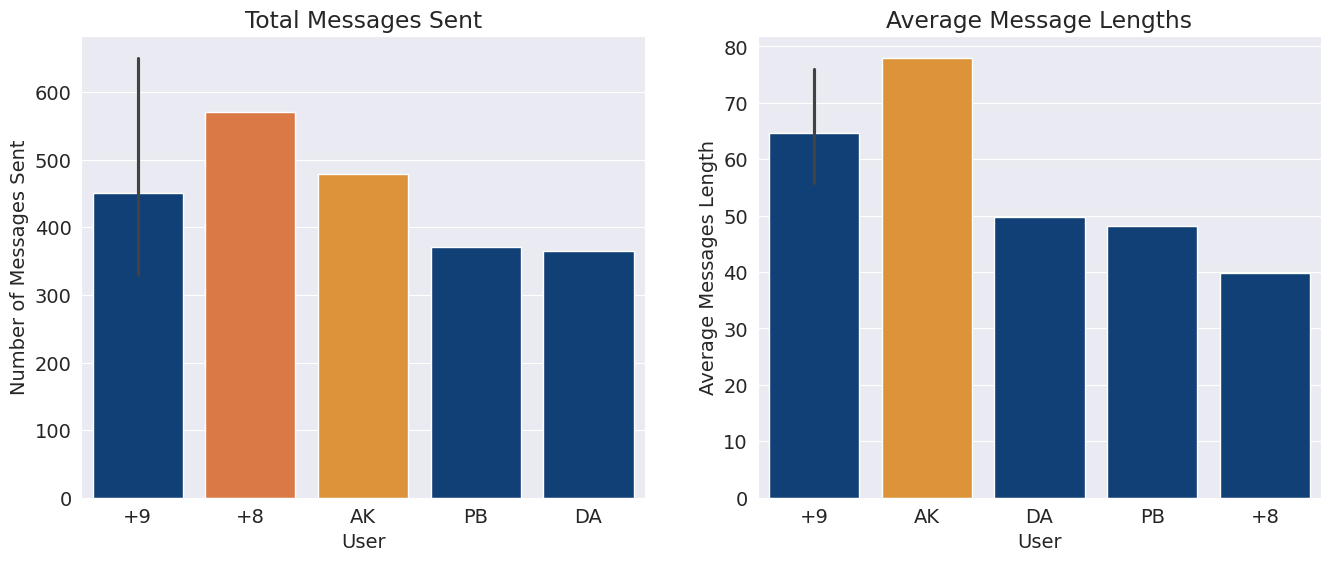

In [26]:
# plotting multiple charts in a grid
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid")

# Plot 1 - Countplot of total messages sent
sns.barplot(x='initials', y='message', data=top10df, ax=axes[0], palette=get_colors_of_certain_order(top10df.initials));  # Use x and y as keyword arguments

axes[0].set_title('Total Messages Sent')
axes[0].set_xlabel('User')
axes[0].set_ylabel('Number of Messages Sent')

# Plot 2 - Barplot of those top 10 users' average message lengths
sns.barplot(x='initials', y='avg_message_length', data=top10df_msg, ax=axes[1], palette=get_colors_of_certain_order(top10df_msg.initials))  # Use x and y as keyword arguments

axes[1].set_title('Average Message Lengths')
axes[1].set_xlabel('User')
axes[1].set_ylabel('Average Messages Length')

# Saving the plots
plt.savefig('top10_msg_plots_diff.svg', format='svg')


### It’s really interesting to see plots like this *side by side*, because here comes the twist:

- Ironically, **TK**, the person who sent the **most amount of texts** (2000+), has ***least*** messages' length on *average*. This means this person sends broken and many WhatsApp messages in one go.

- We can see that, **I** send less number of messages while having a **relatively longer message length**, followed by **KS**.

- Here's a **snippet** of how TK sends messages:

<img src="https://imgur.com/xznZczG.png">

#### "*Things aren't always the way they seem like.*"

# 4. Top 10 users most sent media

- The exported chats were exported without any media files. Any message that contained media was indicated with `‘<Media Omitted> ’`.

### *Pre-processing*
**We can use this to filter out and see who sends the most media.**

In [27]:
# Using `groupby`, `count` and `sort_values` attributes.
top10media = df[df.message == '<Media omitted> '].groupby('user').count().sort_values(by="message", ascending = False).head(10)

# Dropping unused column;
top10media.drop(columns=['date_time', 'day', 'month', 'year', 'date'], inplace=True)

# Renaming column name for visualization;
top10media.rename(columns={"message": "media_sent"}, inplace=True)

# resetting index;
top10media.reset_index(inplace=True)

top10media['initials'] = ''
for i in range(10):
    top10media.initials[i] = top10media.user[i].split()[0][0] + top10media.user[i].split()[1][0]

top10media.initials[2] = "Me"    # That's me
top10media.initials[9] = "VR"

### *Visualization using different Seaborn's Color Palettes*
- [Seaborn References](http://seaborn.pydata.org/tutorial/color_palettes.html#using-circular-color-systems)
- [Seaborn's Different Colors](https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08)
- [Seaborn's Color Visualization](https://python-graph-gallery.com/197-available-color-palettes-with-matplotlib/)

###### QUICK HACK
- to get **all possible Seaborn's color palettes**:
    - Just put a random input `palette="xyz"`
    - It will then show an error, showing all possible palettes you can try out from!

### Which user sends the most media?

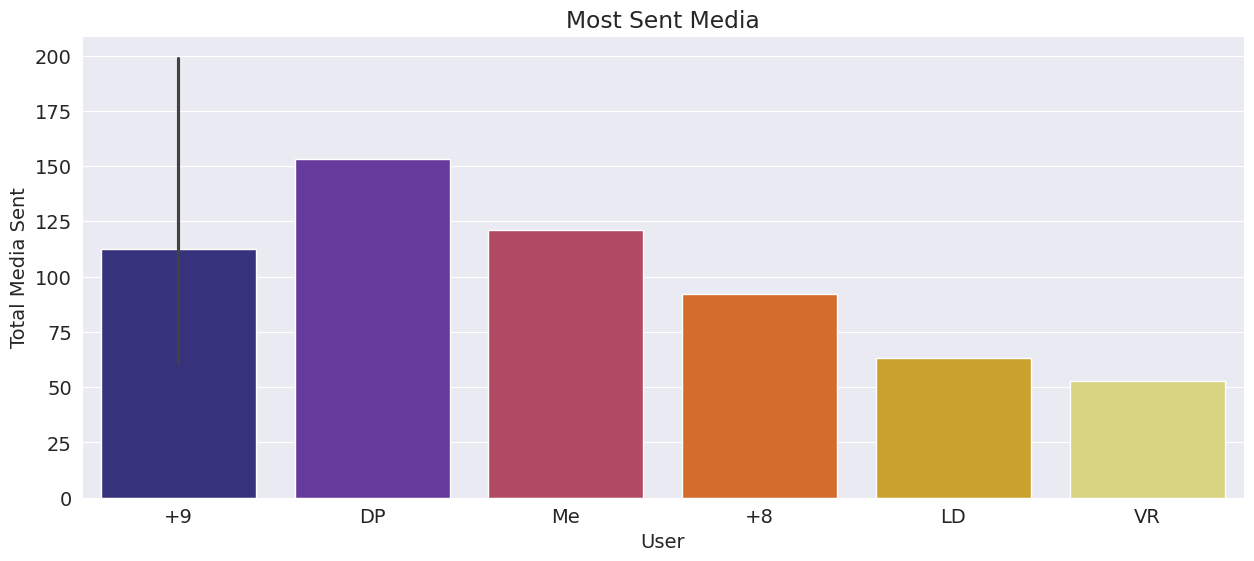

In [28]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting a bar graph;
sns.barplot(x=top10media.initials, y=top10media.media_sent, palette="CMRmap");

plt.title('Most Sent Media')
plt.xlabel('User')
plt.ylabel('Total Media Sent');

# Saving the plots
plt.savefig('top10media.svg', format='svg')


### **TK** is beating everyone by a mile, followed by **DL**. He also ranks the **top** in total messages, *though **last** in average message length*. Most dedicated contributor award goes to **TK**!

# 5. Top 10 most used Emojis
- Will be using the `emoji` module, that was imported earlier.

In [29]:
import regex as re
from collections import Counter

emoji_ctr = Counter()
emoji_pattern = re.compile(r'\p{Emoji}')

for idx, row in df.iterrows():
    emojis_found = emoji_pattern.findall(row["message"])
    for emoji_found in emojis_found:
        emoji_ctr[emoji_found] += 1

# Print emojis and their counts
for emoji, count in emoji_ctr.items():
    print(f"{emoji}: {count}")


💐: 536
😊: 187
1: 2569
☝: 13
😃: 16
9: 1039
3: 1242
0: 2597
2: 2265
5: 1097
🙏: 437
👏: 768
👌: 123
👍: 574
🤝: 9
7: 686
🏻: 167
8: 791
4: 1105
6: 715
🏆: 1
😁: 22
😄: 9
😀: 21
👆: 71
🎉: 36
🎊: 13
🎂: 85
🎈: 8
🌹: 6
🍷: 1
🤩: 6
🏼: 87
🎁: 7
*: 186
🍞: 1
🥯: 1
🍿: 5
🍎: 1
🥳: 12
😂: 10
🧑: 1
🏫: 1
🙂: 19
☕: 2
🍫: 19
🍨: 5
😖: 1
🙌: 9
🎷: 2
✨: 13
🌟: 7
🤣: 4
☺: 13
#: 33
📌: 12
🏽: 39
🥇: 2
🥰: 3
👇: 15
🌺: 3
🙄: 1
😉: 8
🥭: 3
🚍: 3
🚲: 1
🚴: 1
♀: 1
🐅: 1
✍: 1
🕉: 1
🔋: 1
🍵: 1
🏿: 4
🍰: 3
®: 1
🍀: 1
🌸: 1
🌙: 1
😇: 6
❤: 11
🩹: 4
💛: 1
🇮: 3
🇳: 3
✳: 2
🤔: 1
🪜: 1
🚩: 1
📸: 6
😱: 7
🤘: 1
📃: 2
🧾: 1
🔗: 1
🍁: 4
🧐: 4
🧊: 1
🏅: 1
🎖: 1
🥈: 1
💥: 1
👊: 1
🧁: 1
🥧: 1
🍮: 1
🍭: 1
🍬: 2
🍩: 1
⭐: 1
‼: 2
🚀: 1
😎: 4
🤪: 1
🤦: 1
♂: 1
🎟: 1
🤞: 1
🎤: 4
🔥: 4
💯: 1
🙈: 3
😆: 5
😞: 1
😳: 3
💘: 4
✴: 10
▶: 1
🌄: 1
📚: 1
💕: 2
🏀: 1
✅: 1
🖱: 1
😅: 2
😌: 1
🎅: 1
🌻: 1
💔: 1
😵: 1
💫: 1
📱: 1
👋: 1
🕒: 1
🤍: 1
💙: 1
🫡: 6
🍊: 6
💗: 1
🥲: 1
🤯: 1
👿: 1
♥: 1
🙁: 1
😝: 3
🕺: 1
🏓: 1
📞: 1
✔: 1


#### Will create another helper column using `emoji.demojize("<emoji>")`, since emojis will not rendered.

In [30]:
import emoji
import pandas as pd
from collections import Counter

# Assuming you already have emoji_ctr from previous code

top10emojis = pd.DataFrame()
top10emojis['emoji'] = [''] * 10
top10emojis['emoji_count'] = [0] * 10
top10emojis['emoji_description'] = [''] * 10

i = 0
for item in emoji_ctr.most_common(10):
    # Use emoji.demojize from the emoji module
    description = emoji.demojize(item[0])[1:-1]  # Remove the colons ':' at the end of the demojized string

    # Appending top 10 data of emojis.  # Loading into a DataFrame.
    top10emojis.emoji[i] = item[0]
    top10emojis.emoji_count[i] = int(item[1])
    top10emojis.emoji_description[i] = description
    i += 1

top10emojis


,emoji,emoji_count,emoji_description
0,0,2597,
1,1,2569,
2,2,2265,
3,3,1242,
4,4,1105,
5,5,1097,
6,9,1039,
7,8,791,
8,👏,768,clapping_hands
9,6,715,


### Which Emoji is the most used in the chat?

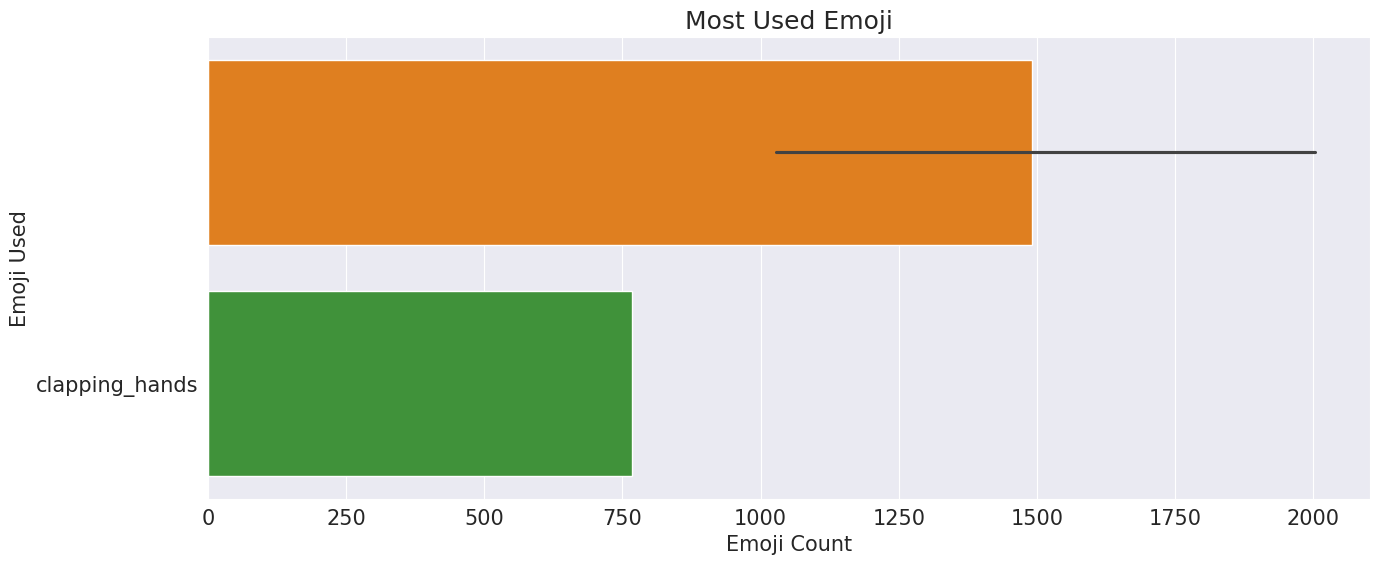

In [31]:
# Increasing the figure size
plt.figure(figsize=(15, 6))

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 15

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# Plotting
sns.barplot(x=top10emojis.emoji_count, y=top10emojis.emoji_description, palette="Paired_r")

plt.title('Most Used Emoji')
plt.xlabel('Emoji Count')
plt.ylabel('Emoji Used')

# Saving the plots
plt.savefig('top10emoji.svg', format='svg')


#### Not that it is worth anything, but "😂" beats everyone by a huge margin!

# 6. Most active days, most active hours, most active months.

### *Pre-processing*

In [32]:
df3 = df.copy()
df3['message_count'] = [1] * df.shape[0]    # helper column to keep a count.

df3['hour'] = df3['date_time'].apply(lambda x: x.hour)

grouped_by_time = df3.groupby('hour').sum().reset_index().sort_values(by = 'hour')

### Which hour of the day are most messages exchanged?

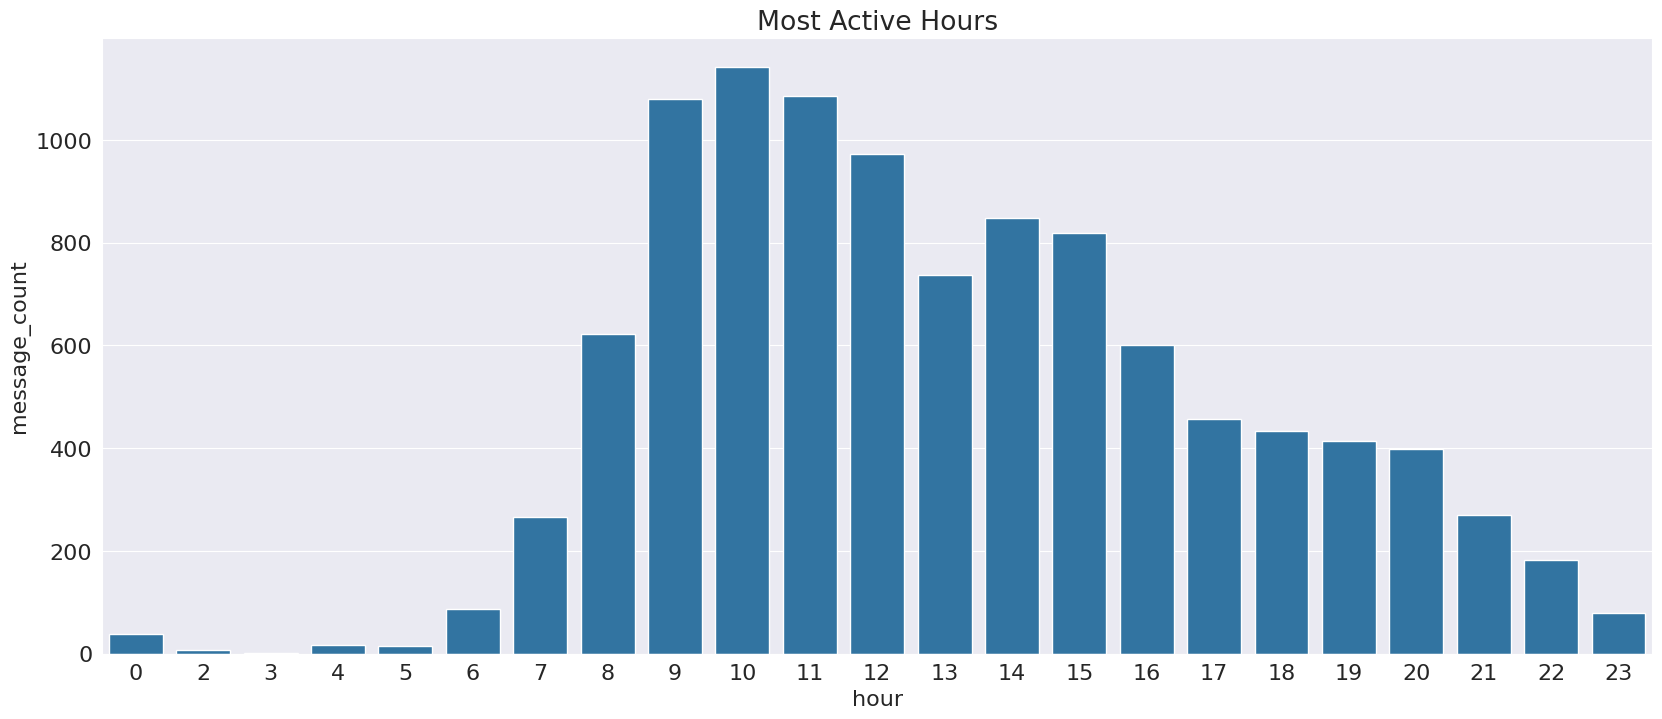

In [33]:
# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (20, 8)

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT: grouped by hour
sns.barplot(x=grouped_by_time.hour, y=grouped_by_time.message_count)
plt.title('Most Active Hours')

# Saving the plots
plt.savefig('most_active_hours.svg', format='svg')


#### Intrestingly, the group is *most active around midnight*, followed by *afternoon*.

### *Pre-processing weekdays and months*

In [34]:
# specific `order` to be printed in;
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
# grouping by day;
grouped_by_day = df3.groupby('day').sum().reset_index()[['day', 'message_count']]


# specific `order` to be printed in;
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep']   # till Sept, since chats are till Septemeber
# grouping by month;
grouped_by_month = df3.groupby('month').sum().reset_index()[['month', 'message_count']]


## *Visualization*
### Now, we will be plotting *grouped by day* and respective *group by month* simultaneously, to see some interesting results.
- Using `plt.subplots` to plot multiple charts in a grid.

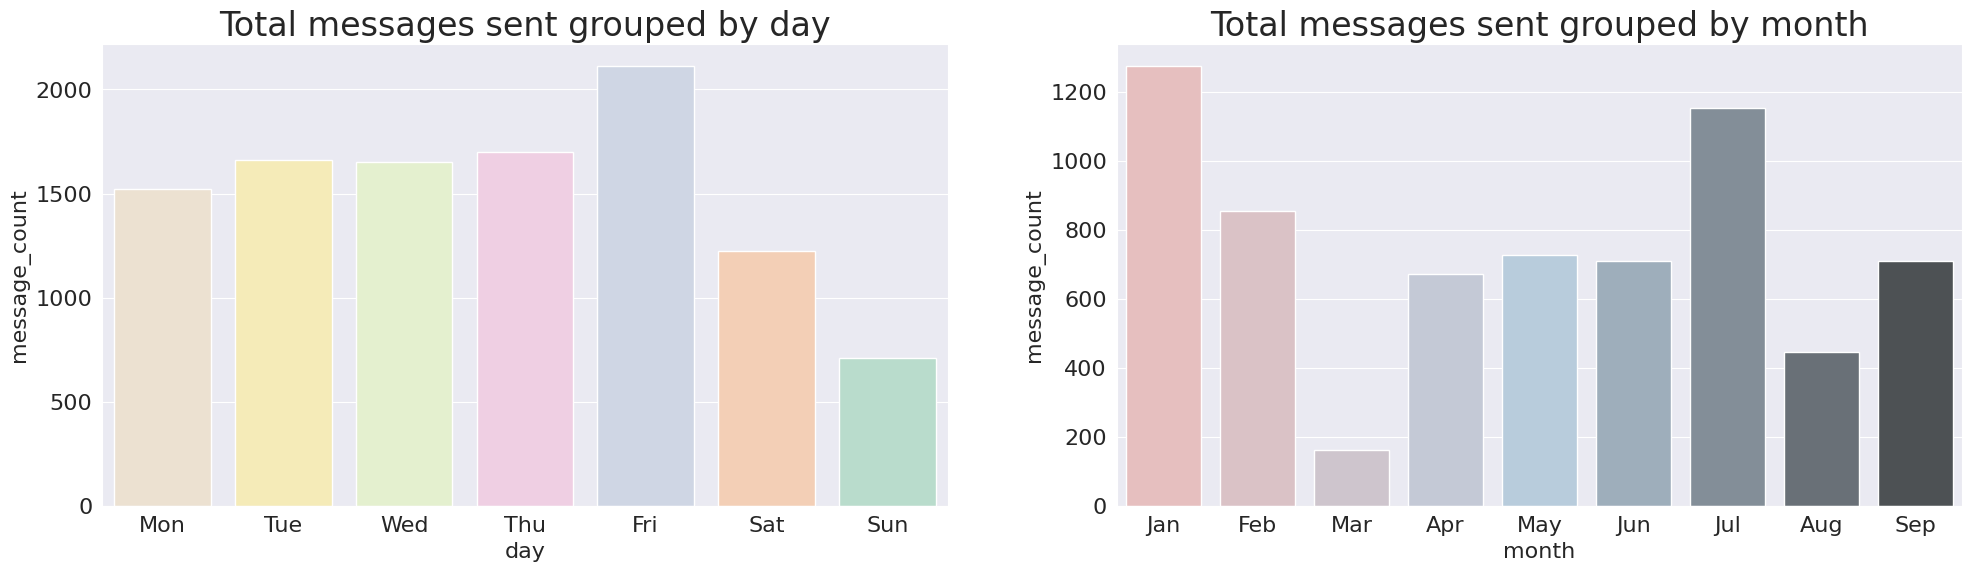

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(24, 6))

# Better Readability
import matplotlib
matplotlib.rcParams['font.size'] = 20

# Beautifying Default Styles using Seaborn
sns.set_style("darkgrid")

# PLOT 1: Messages grouped by weekday
sns.barplot(x='day', y='message_count', data=grouped_by_day, order=days, ax=axs[0], palette='Pastel2_r')
axs[0].set_title('Total messages sent grouped by day')

# PLOT 2: Messages grouped by months
sns.barplot(x='month', y='message_count', data=grouped_by_month, order=months, ax=axs[1], palette='Pastel1_d')
axs[1].set_title('Total messages sent grouped by month')

# Saving the plots
plt.savefig('days_and_month.svg', format='svg')


##### The group is most active on Sundays, and least active on Mondays (probably *Monday Blues*)
##### It has been recently very active, in September.

### Now, we will plot a *heatmap*, combining the above to bar plots, for a better understanding!

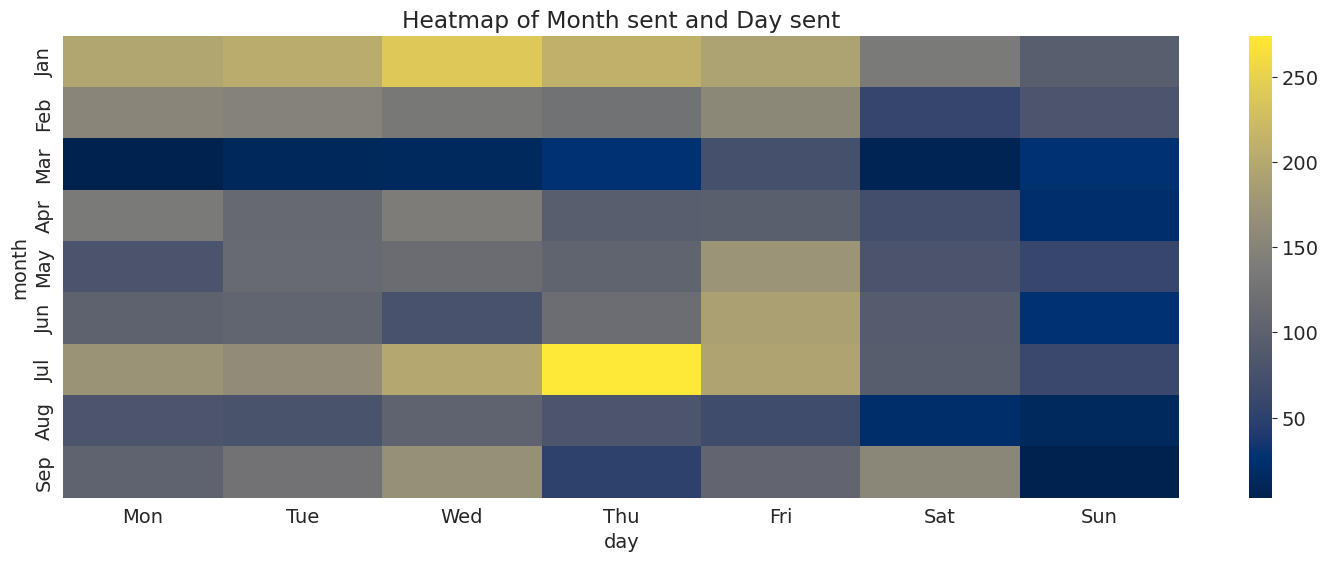

In [36]:
# Better Readablity
import matplotlib
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (18, 6)

# Beautifying Default Styles using Seaborn,
sns.set_style("darkgrid")

# Pre-Processing by month and day,
grouped_by_month_and_day = df3.groupby(['month', 'day']).sum().reset_index()[['month', 'day', 'message_count']]

# creating a pivot table,
pt = grouped_by_month_and_day.pivot_table(index = 'month', columns = 'day', values = 'message_count').reindex(index = months, columns = days)

# PLOT: heatmap.
sns.heatmap(pt, cmap = 'cividis');
plt.title('Heatmap of Month sent and Day sent');

# Saving the plots;
plt.savefig('month_day_heatmap.svg', format = 'svg')

# *Inferences*
- The group is more active on weekends, throughout the months.
- September has the most lighter blue shades and more yellow gradients.
- This gives a combined analysis, which is really helpful in real-time projects.

# Most used words in the chat.
### Finally, I will be ending with *the most used words*, using `WordCloud` module in Python.

In [37]:
comment_words = ' '

# stopwords --> Words to be avoided while forming the WordCloud,
# removed group_notifications like 'joined', 'deleted';
# removed really common words like "yeah" and "okay".
stopwords = STOPWORDS.update(['group', 'link', 'invite', 'joined', 'message', 'deleted', 'yeah', 'hai', 'yes', 'okay', 'ok', 'will', 'use', 'using', 'one', 'know', 'guy', 'group', 'media', 'omitted','student,'])


# iterate through the DataFrame.
for val in df3.message.values:

    # typecaste each val to string.
    val = str(val)

    # split the value.
    tokens = val.split()

    # Converts each token into lowercase.
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    for words in tokens:
        comment_words = comment_words + words + ' '


wordcloud = WordCloud(width = 600, height = 600,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 8).generate(comment_words)

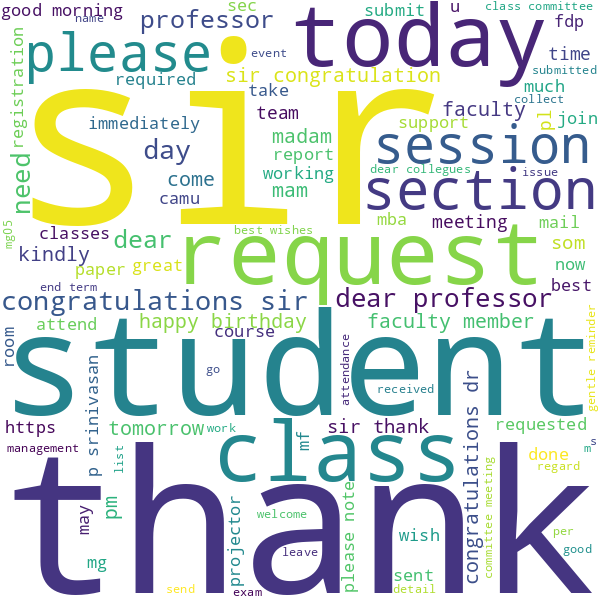

In [38]:
wordcloud.to_image()

# *Conclusion*

- The insights were really interesting to look at!

- We first loaded the data as a .txt file coverted it using `RawtoDF` function.
- Then  we added helper columns, manipulated datetime entries.
- Then, we started analysing our whatsapp data!

Here is what we looked at!

**1. Overall frequency of total messages on the group.**

**2. Top 10 most active days.**

**3. Top 10 active users on the group (with a twist - Most active user had the least average message length ).**
- Ghosts present in the group. (shocking results - 80+ participants who haven't even sent a single message!)

**4. Top 10 users most sent media.**
- *TK* beats everyone by a mile!

**5. Top 10 most used emojis.**
- using the `emoji` module!

**6. Most active hours and weekdays.**
 - Heatmaps of weekdays and months.
 - Most active hours, weekdays, and months.

**7. Most used words - WordCloud**

### That's it from my end! I hope you *learnt and enjoyed* a lot!

# *Where to go from here?*

- Extending this **Whatsapp Ananlysis Project**!
  - Adding a **Sentiment Analyser to the texts** - Swear Words & Sentiments!
  - Libraries called `profanity_check`, `TextBlob`
  - VADER (Valence Aware Dictionary and Sentiment Reasoner) from NTLK and TextBlob.
- Instagram Data Analysis
- Play Store Data Analysis
- Exploring more datasets! It is *never-ending*, as there can be ***Infinite Stories with Data***!
- Once, done with enough Data Analysis, try making Datasets, scraping Data from websites and creating Interesting Datasets!

# *Thank You*
- [Tushar Nankani](https://www.linkedin.com/in/tusharnankani/)